In [55]:
import torch
import torchvision
from torchvision import transforms,models
from PIL import Image
import matplotlib.pyplot as plt
from torch.autograd import Variable
import copy 
import numpy as np

In [56]:

#! 图片读取
#* 定义图片转换方式
transform = transforms.Compose([transforms.Scale([224,224]),transforms.ToTensor()])

#* 使用Image读取图片
src_img_path = "./source.jpg"
mod_img_path = "./model.jpg"

#* 载入图片
def loading_img(path):
    img = Image.open(path)
    img = transform(img)
    img = img.unsqueeze(0)

    return img

#* 显示图片
def showing_img(img,title=None):
    #! 需要将tensor转换为PIL Image
    img = img.view((3,224,224))
    ToPIL = torchvision.transforms.ToPILImage()
    img = ToPIL(img)

    print(type(img))

    if title is not None:
        plt.title(title)
    plt.imshow(img)

<class 'PIL.Image.Image'>


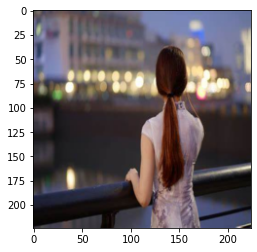

In [57]:
img = loading_img(src_img_path)
img = np.array(img)
img = torch.from_numpy(img)
showing_img(img)

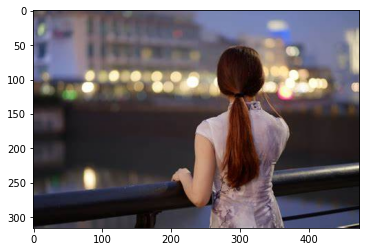

In [58]:
img = Image.open(src_img_path)
plt.imshow(img)

In [59]:

#! 定义内容Loss，风格Loss以及Gram矩阵
class Content_loss(torch.nn.Module):
    def __init__(self,weight,target):
        super().__init__()
        self.weight = weight
        self.target = target.detach()*weight
        self.loss_fn = torch.nn.MSELoss()
        #! 定义损失函数
    
    def forward(self,input):
        self.loss = self.loss_fn(input*self.weight,self.target)
        self.output = input

        return self.output

    def backward(self):
        self.loss.backward(retain_gragh=True)
        return self.loss
        

In [60]:
class gram_matrix(torch.nn.Module):
    def forward(self, input):
        a,b,c,d = input.size()
        feature = input.view(a*b, c*d)
        gram = torch.mm(feature, feature.t())
        return gram.div(a*b*c*d)

In [61]:
class Style_loss(torch.nn.Module):
    def __init__(self, weight, target):
        super(Style_loss, self).__init__()
        self.weight = weight
        self.target = target.detach()*weight
        self.loss_fn = torch.nn.MSELoss()
        self.gram = gram_matrix()
        
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.loss_fn(self.G, self.target)
        return self.output
    def backward(self):
        self.loss.backward()
        return self.loss

In [62]:
use_gpu = torch.cuda.is_available()
cnn = models.vgg16(pretrained=True).features
if use_gpu:
    cnn = cnn.cuda()

In [63]:
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [64]:
content_layer = ["Conv_5","Conv_6"]

style_layer = ["Conv_1", "Conv_2", "Conv_3", "Conv_4", "Conv_5"]

content_img = loading_img("./source.jpg")
content_img = Variable(content_img).cuda()
style_img = loading_img("./model.jpg")
style_img = Variable(style_img).cuda()

content_losses = []
style_losses = []

conten_weight = 1
style_weight = 1000

new_model = torch.nn.Sequential()

model = copy.deepcopy(cnn)

gram = gram_matrix()

if use_gpu:
    new_model = new_model.cuda()
    gram = gram.cuda()

index = 1
for layer in list(model):
    if isinstance(layer, torch.nn.Conv2d):
        name = "Conv_"+str(index)
        new_model.add_module(name, layer)
        if name in content_layer:
            target = new_model(content_img).clone()
            content_loss = Content_loss(conten_weight, target)
            new_model.add_module("content_loss_"+str(index), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layer:
            target = new_model(style_img).clone()
            target = gram(target)
            style_loss = Style_loss(style_weight, target)
            new_model.add_module("style_loss_"+str(index), style_loss)
            style_losses.append(style_loss)
            
    if isinstance(layer, torch.nn.ReLU):
        name = "Relu_"+str(index)
        new_model.add_module(name, layer)
        index = index+1
            
    if isinstance(layer, torch.nn.MaxPool2d):
        name = "MaxPool_"+str(index)
        new_model.add_module(name, layer)

print(new_model)

Sequential(
  (Conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): Style_loss(
    (loss_fn): MSELoss()
    (gram): gram_matrix()
  )
  (Relu_1): ReLU(inplace=True)
  (Conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): Style_loss(
    (loss_fn): MSELoss()
    (gram): gram_matrix()
  )
  (Relu_2): ReLU(inplace=True)
  (MaxPool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): Style_loss(
    (loss_fn): MSELoss()
    (gram): gram_matrix()
  )
  (Relu_3): ReLU(inplace=True)
  (Conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_4): Style_loss(
    (loss_fn): MSELoss()
    (gram): gram_matrix()
  )
  (Relu_4): ReLU(inplace=True)
  (MaxPool_5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_5): Conv2d(128, 256, k

In [65]:
input_img = content_img.clone()

parameter = torch.nn.Parameter(input_img.data)
optimizer = torch.optim.LBFGS([parameter])

In [66]:
n_epoch = 1000

run = [0]
while run[0] <= n_epoch:

    def closure():
        optimizer.zero_grad()
        style_score = 0
        content_score = 0
        parameter.data.clamp_(0,1)
        new_model(parameter)
        for sl in style_losses:
            style_score += sl.backward()
        
        for cl in content_losses:
            content_score += cl.backward()
        
        run[0] += 1 
        if run[0] % 50 == 0:
            print('{} Style Loss : {:4f} Content Loss: {:4f}'.format(run[0],
                 style_score.data[0], content_score.data[0])) 

        return style_score+content_score
    


    optimizer.step(closure)

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling .backward() or autograd.grad() the first time.